## Machine Learning Analysis on the Dynamical Origin of Rebound vs Dissociation Selectivity During Fe-Oxo mediated C-H Functionalization Reactions.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import time
import shap
import graphviz
#--------------------------------------------------------
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix, accuracy_score, log_loss
import time
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit, cross_validate, cross_val_score, train_test_split,KFold,StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
#--------------------------------------------------------

In [2]:
dataset=pd.read_csv('Dyn_KE+QN+ModeVel+ModeE_Extracted.csv')

In [3]:
dataset.head()

,outcome,KE_CyHex,KE_FeO,KE_H70,Q.No_1,Q.No_2,Q.No_3,Q.No_4,Q.No_5,Q.No_6,...,Mod_Ener_21,Mod_Ener_22,Mod_Ener_23,Mod_Ener_24,Mod_Ener_25,Mod_Ener_26,Mod_Ener_27,Mod_Ener_28,Mod_Ener_29,Mod_Ener_30
0,0,97.047603,310.447135,8.305618,6,0,25,2,7,1,...,0.235616,0.246148,0.272052,0.276581,0.292681,0.894454,0.308636,0.333339,0.337582,0.355769
1,0,100.045317,312.321600,2.758199,40,0,26,7,0,4,...,0.235616,0.246148,0.272052,0.276581,0.292681,0.894454,0.308636,0.333339,0.337582,0.355769
2,0,100.473551,313.270043,3.393492,46,9,12,4,7,8,...,0.706848,0.246148,0.272052,0.276581,0.878042,0.298151,0.308636,0.333339,1.012746,0.355769
3,0,106.290849,309.410672,2.326584,39,48,21,12,2,6,...,0.235616,0.246148,0.272052,0.276581,0.292681,0.298151,0.308636,1.000018,1.012746,1.067306
4,0,101.045191,317.266976,1.650577,65,0,17,5,3,10,...,0.235616,0.246148,0.272052,0.829742,0.292681,0.894454,0.308636,2.333376,1.687910,1.067306


In [4]:
dataset['outcome'].value_counts()

0    50
1    50
Name: outcome, dtype: int64

<AxesSubplot: >

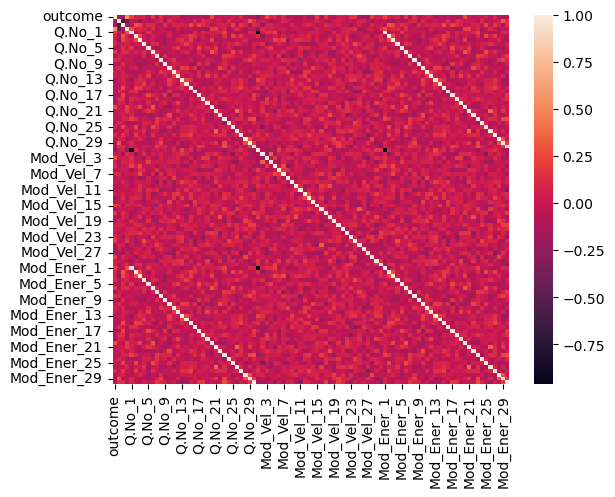

In [5]:
sns.heatmap(dataset.corr())

### Train-Test Data Split

In [6]:
# Assign Features and Labels
X = dataset.drop(['outcome'],axis=1)
y = dataset['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  stratify=dataset['outcome'], random_state=101)

sc = StandardScaler()
#scaler = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape , X_test.shape)

(80, 93) (20, 93)


In [7]:
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{dataset["outcome"].value_counts() / len(dataset)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{y_train.value_counts() / len(y_train)}\n\n'+
      f'PROPORTION OF TARGET IN THE TEST SET\n{y_test.value_counts() / len(y_test)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
0    0.5
1    0.5
Name: outcome, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
0    0.5
1    0.5
Name: outcome, dtype: float64

PROPORTION OF TARGET IN THE TEST SET
1    0.5
0    0.5
Name: outcome, dtype: float64


## LightGBM Classifier

In [8]:
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

LGBMClassifier()

In [9]:
from sklearn.model_selection import cross_val_score

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True)

# Perform cross-validation
cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=stratified_kfold)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Scores: [0.625 0.75  0.375 0.625 0.875 1.    0.375 0.75  0.75  0.875]
Mean Accuracy: 0.70


In [10]:
# gradboost_model.get_params()

## Hyper Parameter Tuning

In [11]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to search
param_grid = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [-1, 5, 10, 15, 20], 'num_leaves': [2, 3, 4, 5, 6]}

# Perform grid search
grid_search = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'max_depth': -1, 'n_estimators': 200, 'num_leaves': 2}


In [12]:
lgbm_opt_model = LGBMClassifier(**best_params)
lgbm_opt_model.fit(X_train, y_train)

LGBMClassifier(n_estimators=200, num_leaves=2)

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True)

# Perform cross-validation
cv_scores = cross_val_score(lgbm_opt_model, X_train, y_train, cv=stratified_kfold)  

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Train Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Scores: [0.625 0.5   0.75  1.    0.75  1.    0.875 0.625 0.625 1.   ]
Mean Train Accuracy: 0.78


In [14]:
test_accuracy = lgbm_opt_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.80


## SHAP Analysis --- Feature Importance

In [15]:
# Initialize JavaScript visualizations in notebook environment
shap.initjs()

# creating an explainer for our model
explainer = shap.TreeExplainer(lgbm_opt_model)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(X_train)

# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

Expected Value: [0.058833354199194624, -0.058833354199194624]


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


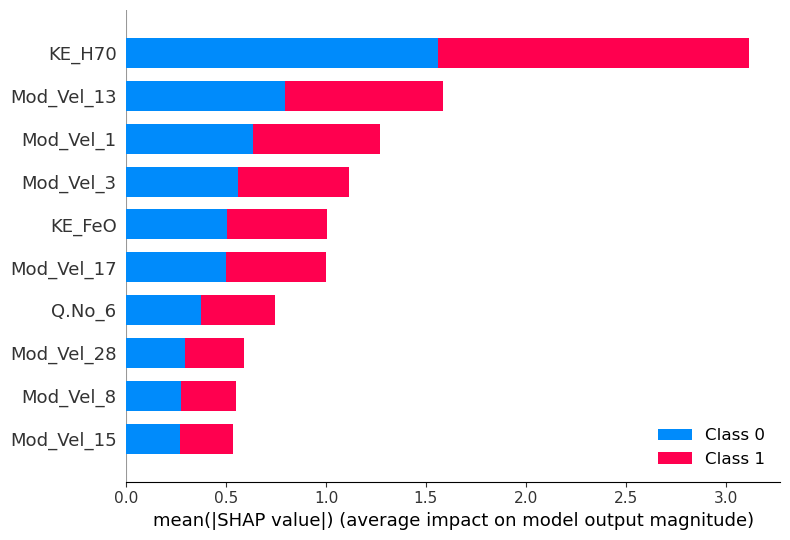

In [16]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=10)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


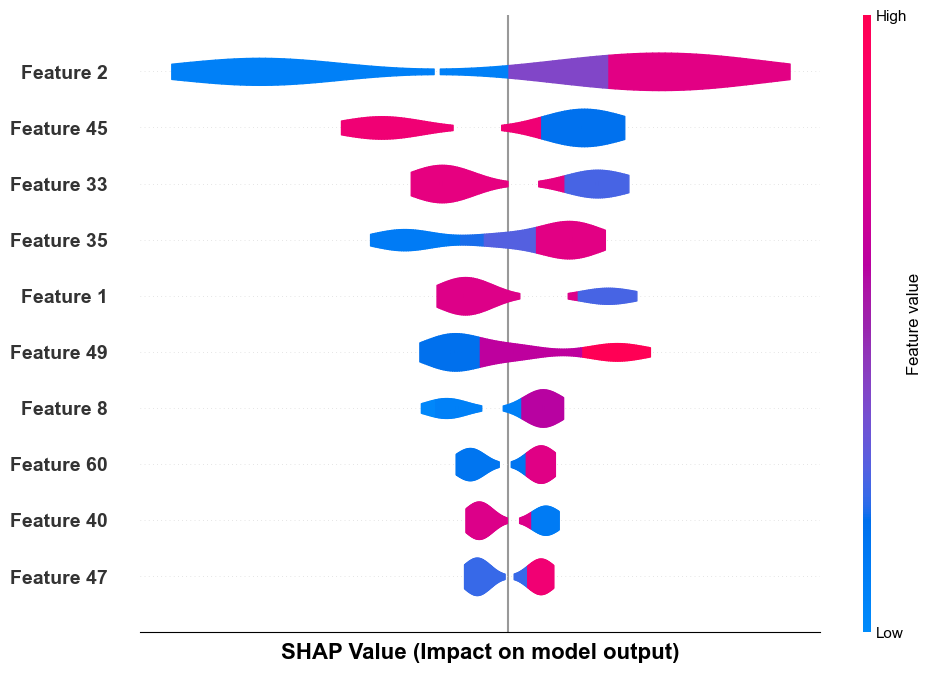

In [20]:
shap.summary_plot(shap_values[1], X_train, max_display=10, plot_type='violin', plot_size=(10,7), color_bar=True, show=False)

plt.xlabel('SHAP Value (Impact on model output)', fontweight='bold', fontsize=16)
plt.xticks(fontweight='bold', fontsize=14, ticks=[])
plt.yticks(fontweight='bold', fontsize=14)

# plt.savefig('SHAP-LGBM.png', dpi=300)

In [18]:
lgbm_opt_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 2,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

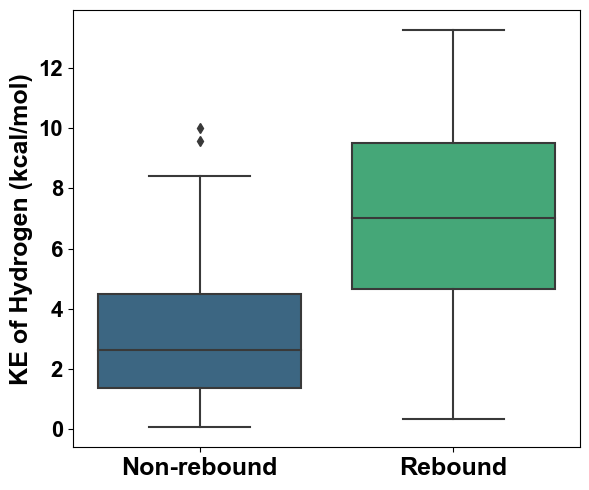

In [19]:
plt.figure(figsize=(6,5), tight_layout=True)
plt.rcParams['font.family'] = 'Arial'

sns.boxplot(x=dataset['outcome'], y = dataset['KE_H70'], palette='viridis')

plt.xlabel('', fontweight='bold', fontsize=18)
plt.ylabel('KE of Hydrogen (kcal/mol)', fontweight='bold', fontsize=18)
# plt.title('Optimized Model Accuracy', fontweight='bold', fontsize=16)

tick_labels = ['Non-rebound', 'Rebound']
plt.xticks(range(len(tick_labels)), tick_labels, fontweight='bold', fontsize=18)
plt.yticks(fontweight='bold', fontsize=16)

# plt.xlim(-1, len(opt_labels)-0.1)

plt.savefig('KE_H70 Box_Plot', dpi=300)